# Pre-trained word embeddings

## Importações

In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from __future__ import print_function

import os
import sys
import numpy as np
import numpy.random as nr

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

import os
os.makedirs('../../models',exist_ok=True)

Using TensorFlow backend.


In [2]:
import keras.backend as K

# K.set_image_data_format('channels_first')
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


## Training procedure

In [3]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        pass


def build_model(model_name, build_model_fun, reset=False, **kwargs):
    if reset and os.path.isfile(model_name + '.model'):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_name + '.model'):
        print(kwargs.keys())
        print("[INFO] creating model...")
        model = build_model_fun(**kwargs)

        # History, checkpoint, earlystop, plot losses:
        my_cb = MyCb(n=1, filepath=model_name, patience=1000, plot_losses=False)

        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])    

    else:
        print("[INFO] loading model...")
        model, my_cb = load_model_and_history(model_name)

    return model, my_cb
    
    
def train_network(model, cb, Xtra, ytra, Xval=None, yval=None, opt='rmsprop', 
                  batch_size=60, nepochs=50, patience=50, nr_seed=20170512, ploss=1.0):
    
    nr.seed = nr_seed
    cb.patience = patience
#     model.optimizer = opt
    
    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs

    #     fig = plot.figure(figsize=(15,6))
    #     plot.ylim(0.0, ploss)
    #     plot.xlim(0, nepochs)
    #     plot.grid(True)

    print("[INFO] training for {} epochs ...".format(tr_epochs))
    try:
        h = model.fit(Xtra, ytra, batch_size=60, epochs=tr_epochs, verbose=1, 
                      validation_data=(Xval, yval), callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model


def test_network(model_name, Xtest, ytest, batch_size=64):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


## Preparação do dataset

In [4]:
BASE_DIR = '../../datasets/'
GLOVE_DIR     = BASE_DIR + 'glove.6B/'
TEXT_DATA_DIR = BASE_DIR + '20_newsgroup/'

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS        = 20000
EMBEDDING_DIM       = 100
VALIDATION_SPLIT    = 0.2

In [5]:
# first, build index mapping words in the embeddings set
# to their embedding vector
print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Indexing word vectors.
Found 400000 word vectors.


In [6]:
# second, prepare text samples and their labels
print('Processing text dataset')

texts = []         # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []        # list of label ids

for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='latin-1')
                t = f.read()
                i = t.find('\n\n')  # skip header
                if 0 < i:
                    t = t[i:]
                texts.append(t)
                f.close()
                labels.append(label_id)

print('Found %s texts.' % len(texts))

Processing text dataset
Found 19997 texts.


In [7]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating='post', padding='post')

targets = to_categorical(np.asarray(labels))

# data = data[:5000]
# labels = labels[:5000]

print('Shape of data tensor:', data.shape, data.max())
print('Shape of label tensor:', targets.shape)

Found 174074 unique tokens.
Shape of data tensor: (19997, 1000) 19999
Shape of label tensor: (19997, 20)


Seq. length min/max/mean/median: 0 27442 266.008101215 150.0
Word indexes min/max: 0 19999

 3563: in article 1993apr19 julian uwo ca wlsmith valve heart rri uwo ca wayne smith writes stuff deleted so the lowly low density original pc fdd card used dma and the pc at hdd controller doesn't that makes real sense actually it does make a reasonable amount of sense fixed disk

 2393: since i started this twist of this thread kdb acpub duke edu kurt bollacker writes i believe that enough is inferior to make it overall as a product inferior to its competition apple system 7 os 2 2 0 nextstep 3 0 unix xwindows pick your favorite flavor in other

  368: livesey solntze wpd sgi com jon livesey writes explain to me how instinctive acts can be moral acts and i am happy to listen for example if it were instinctive not to murder then not murdering would have no moral significance since there would be nothing voluntary about it see

 4936: i am running system 7 1 on a centris 610 i have not been able

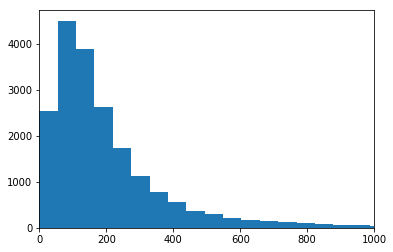

In [8]:
nn = np.array([len(seq) for seq in sequences])
print('Seq. length min/max/mean/median:', nn.min(), nn.max(), nn.mean(), np.median(nn))

print('Word indexes min/max:', data.min(), data.max(), end='\n\n')

plot.hist(nn, bins=500)
plot.xlim(0, 1000)

i2w = dict([(v, k) for k, v in word_index.items()])

for i in nr.randint(5000, size=5):
    seq = data[i]
    print('{:5d}: {}\n'.format(i, ' '.join([i2w[x] for x in seq[:50] if x > 0])))

In [9]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
targets = targets[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = targets[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = targets[-num_validation_samples:]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)


(15998, 1000) (15998, 20)
(3999, 1000) (3999, 20)


In [10]:
print('Preparing embedding matrix: ', end='')

# prepare embedding matrix
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

# for word, i in word_index.items():
#     if i >= MAX_NB_WORDS:
#         continue
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # words not found in embedding index will be all-zeros.
#         embedding_matrix[i] = embedding_vector

i2w = dict([(v, k) for k, v in word_index.items()])

for i in range(1, MAX_NB_WORDS):
    word = i2w[i]
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)
embeddings_index = None

Preparing embedding matrix: (20000, 100)


In [11]:
aa = embedding_matrix.sum(1)
aa[aa==0].shape

(2104,)

## Criação do modelo

In [12]:
model_name = '../../models/word_embeddings_1'

def build_net(embedding_matrix=None, input_len=None, trainable=False):
    num_words, embedding_dim = embedding_matrix.shape
    
    seq_input = Input(shape=(input_len,), dtype='int32')
    embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix],
                                input_length=input_len, trainable=trainable)(seq_input)

    x = Conv1D(128, 5, activation='relu')(embedding_layer)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    preds = Dense(len(labels_index), activation='softmax')(x)

    model = Model(seq_input, preds)
    return model


In [ ]:
build_params = {
    'embedding_matrix': embedding_matrix,
    'input_len':        MAX_SEQUENCE_LENGTH,
    'trainable':        False,
}
model, cb = build_model(model_name, build_net, reset=True, **build_params)
model.summary()

dict_keys(['input_len', 'trainable', 'embedding_matrix'])
[INFO] creating model...
[INFO] compiling model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         2000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 97, 128)           0         
_________________________________

## Treinamento

In [ ]:
fit_params = {
    'opt':             'adam',     #SGD(lr=0.01, momentum=0.9, nesterov=True), 
    'batch_size':      64, 
    'nepochs':         50, 
    'patience':        10,
    'nr_seed':         20170601,
    'ploss':           1.0,
}

train_network(model, cb, x_train, y_train, x_val, y_val, **fit_params);

[INFO] training for 50 epochs ...
Train on 15998 samples, validate on 3999 samples
Epoch 1/50
15998/15998 [==============================] - 10s - loss: 2.4923 - acc: 0.1446 - val_loss: 2.2073 - val_acc: 0.2063

## Avaliação

In [ ]:
test_network(model_name, x_val, y_val)